# Brain Tumor Classification - Stage Prediction

**Objective:** Build a machine learning model to classify brain tumor cancer stages (1-4) based on clinical and imaging features.

**Evaluation Metric:** F1 Score

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Load Data

In [2]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nFirst few rows of training data:")
train_df.head()

Training data shape: (7000, 20)
Test data shape: (3000, 19)

First few rows of training data:


,tumor_type,size,location,edema,necrosis,enhancement,shape,margins,calcification,cystic_components,hemorrhage,ki67_index,mitotic_count,age,gender,symptoms_duration,neurological_deficit,kps_score,cancer_stage,id
0,pituitary,khlat_3lik,frontal,1,0,none,irregular,poorly_defined,1,0,0,100.0,19,65,female,233,0,90,IV,0
1,glioma,normal_brk,frontal,0,0,none,irregular,well_defined,0,1,0,40.0,13,84,amira,233,1,60,IV,1
2,metastatic,normal_brk,occipital,1,0,mild,irregular,well_defined,1,0,0,95.0,2,79,wa7ch,19,1,60,IV,2
3,meningioma,normal_brk,frontal,1,1,none,irregular,poorly_defined,1,0,0,100.0,13,71,wa7ch,157,0,80,IV,3
4,meningioma,normal_brk,brainstem,0,1,ring,irregular,well_defined,0,0,0,25.0,18,31,amira,207,1,90,IV,4


## 3. Exploratory Data Analysis (EDA)

In [ ]:
# Basic info
print("Dataset Info:")
print(train_df.info())
print("\n" + "="*50)
print("\nDataset Description:")
print(train_df.describe())
print("\n" + "="*50)
print("\nMissing Values:")
print(train_df.isnull().sum())
print("\n" + "="*50)
print("\nTarget Variable (Cancer Stage) Distribution:")
print(train_df['cancer_stage'].value_counts())
print("\nTumor Type Distribution:")
print(train_df['tumor_type'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tumor_type            7000 non-null   object 
 1   size                  7000 non-null   object 
 2   location              7000 non-null   object 
 3   edema                 7000 non-null   int64  
 4   necrosis              7000 non-null   int64  
 5   enhancement           7000 non-null   object 
 6   shape                 7000 non-null   object 
 7   margins               7000 non-null   object 
 8   calcification         7000 non-null   int64  
 9   cystic_components     7000 non-null   int64  
 10  hemorrhage            7000 non-null   int64  
 11  ki67_index            7000 non-null   float64
 12  mitotic_count         7000 non-null   int64  
 13  age                   7000 non-null   int64  
 14  gender                7000 non-null   object 
 15  symptom

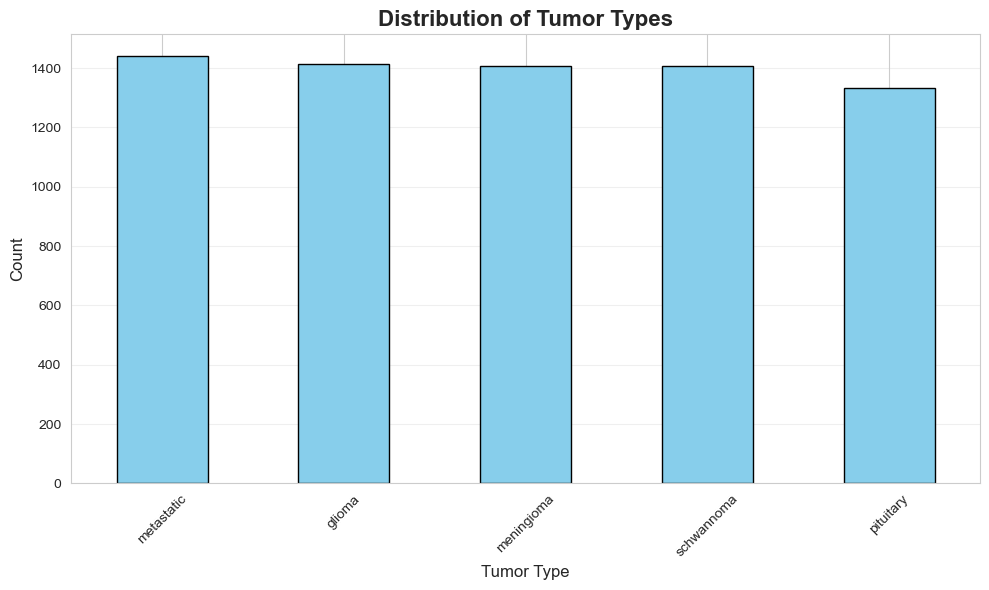

In [ ]:
# Visualize cancer stage distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cancer Stage Distribution
train_df['cancer_stage'].value_counts().sort_index().plot(kind='bar', color='coral', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Cancer Stages', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Cancer Stage', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Tumor Type Distribution
train_df['tumor_type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Tumor Types', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Tumor Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

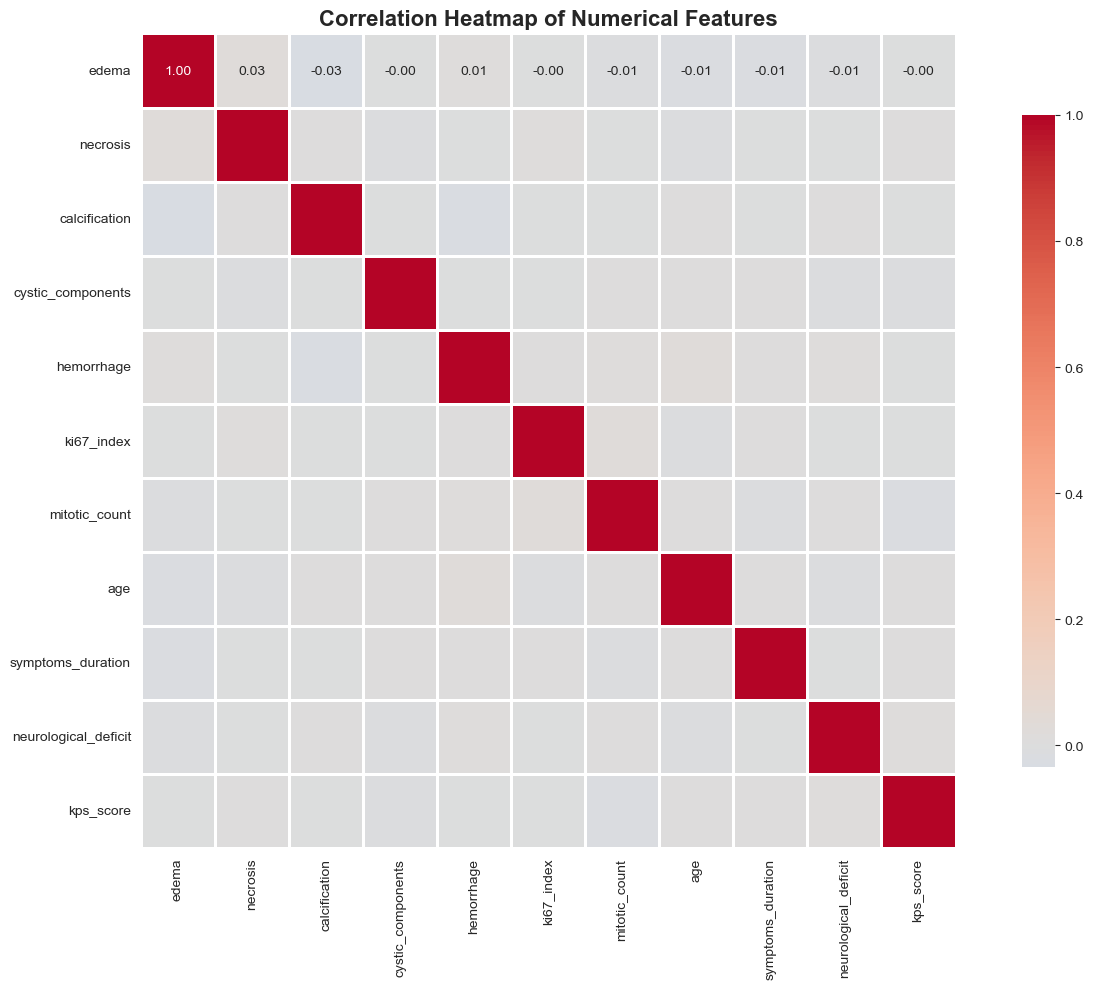

In [5]:
# Correlation heatmap for numerical features
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')

plt.figure(figsize=(14, 10))
correlation_matrix = train_df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [ ]:
# Separate features and target
X = train_df.drop(['cancer_stage', 'id'], axis=1)
y = train_df['cancer_stage']
test_ids = test_df['id']
X_test = test_df.drop(['id'], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nTarget variable distribution:")
print(y.value_counts())
print(f"\nCategorical columns to encode:")
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

Features shape: (7000, 18)
Target shape: (7000,)

Feature columns: ['size', 'location', 'edema', 'necrosis', 'enhancement', 'shape', 'margins', 'calcification', 'cystic_components', 'hemorrhage', 'ki67_index', 'mitotic_count', 'age', 'gender', 'symptoms_duration', 'neurological_deficit', 'kps_score', 'cancer_stage']

Categorical columns to encode:
['size', 'location', 'enhancement', 'shape', 'margins', 'gender', 'cancer_stage']


In [7]:
# Encode categorical variables
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print("\nEncoding complete!")

Encoded size: 5 unique values
Encoded location: 6 unique values
Encoded enhancement: 5 unique values
Encoded shape: 2 unique values
Encoded margins: 2 unique values
Encoded gender: 4 unique values


KeyError: 'cancer_stage'

In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

## 5. Model Training

In [ ]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

# Evaluation
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"\nRandom Forest Results:")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

In [ ]:
# Classification Report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val))

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, 
            yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15], color='teal')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## 6. Make Predictions on Test Set

In [ ]:
# Make predictions on test set
test_predictions = rf_model.predict(X_test)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predicted classes: {np.unique(test_predictions)}")
print(f"\nPrediction distribution:")
print(pd.Series(test_predictions).value_counts())

## 7. Create Submission File

In [ ]:
# Create submission with predicted cancer stages
submission = pd.DataFrame({
    'id': test_ids,
    'cancer_stage': test_predictions
})

print("Cancer stage predictions:")
print(submission['cancer_stage'].value_counts().sort_index())
print(f"\nTotal predictions: {len(submission)}")

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'cancer_stage': cancer_stages
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
print(f"\nFirst few rows of submission:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

# Verify format matches sample_submission
print(f"\nSample submission shape: {sample_submission.shape}")
print("Format verification: ", submission.columns.tolist() == sample_submission.columns.tolist())

## Next Steps

1. **Improve Stage Mapping**: The current mapping from tumor characteristics to cancer stages is simplistic. Consider:
   - Training a model directly on stage labels if available
   - Consulting medical literature for better feature-to-stage mappings
   - Using more sophisticated rules based on multiple features

2. **Model Improvements**:
   - Try other algorithms (XGBoost, LightGBM, Neural Networks)
   - Perform hyperparameter tuning
   - Create ensemble models
   - Handle class imbalance if present

3. **Feature Engineering**:
   - Create interaction features
   - Bin numerical features
   - Extract domain-specific features

4. **Validation Strategy**:
   - Use cross-validation for more robust evaluation
   - Check if there's a separate validation set with cancer stage labels